In [28]:
from srm_helper import *
import pandas as pd
import random as rd
import numpy as np
from sklearn.model_selection import KFold 
from sklearn.metrics import r2_score
import matplotlib
matplotlib.rcParams['figure.dpi'] = 500

In [27]:
tol = .5  # MS2 fragment tolerance for QqQ optimized transitions
ppmTol = 10  # m/z tolerance for HRMS data in ppm
numCores = 2  # number of CPU cores to use
num2Train = 10 #number of compounds to learn equation
numIters = 1000 #number of iterations

In [8]:
### format csv files from whole transition list
totalTransitionInfoFn = "../data/IDX/M3T_transitions_ALTIS_optimized_allCpds.csv"

totalTransitions = pd.read_csv(totalTransitionInfoFn)

switcher = {"Positive":1,"Negative":-1}



In [9]:

allCpds = list(set(totalTransitions["Name"].values))
numCpds = len(allCpds)

In [10]:
if __name__ == '__main__':
    
    targets = totalTransitions
    cpds = []
    toDrop = []
    for index,row in targets.iterrows():
        if (row['Name'],row["Charge"]) in cpds:
            toDrop.append(index)
        else:
            cpds.append((row['Name'],row["Charge"]))

    targets = targets.drop(toDrop)
    goodCols = ["Name","rt_start","rt_end","mz","Charge"]
    targets = targets[goodCols]
    targets.to_csv("tmp_targets_for_evaluation.csv",index=False)

    # create srm_maker object
    srm_maker = SRM_maker(ppm=ppmTol, numCores=numCores)

    msFilenames = ["../data/IDX/IDX_MS2_data/M3T_10uM_pos_DDA_10NCEs_25-35_50ms_5e4_DE5s_updatedRT.mzML",
                   "../data/IDX/IDX_MS2_data/M3T_10uM_neg_DDA_10NCEs_25-35_50ms_5e4_DE5s_updatedRT.mzML",
                   "../data/IDX/IDX_MS2_data/M3T_10uM_pos_DDA_10NCEs_25-35_80ms_1e4_DE5s_updatedRT_missing.mzML"]


    # set datafiles to build srms
    targets = pd.read_csv("tmp_targets_for_evaluation.csv")

    srm_table = pd.DataFrame()
    breakdownCurves = {}

    for msFilename in msFilenames:

        # create SRM table
        srm_table1, _ = srm_maker.createSRMsCE(msFilename, targets)

        srm_table = pd.concat((srm_table,srm_table1),axis=0,ignore_index=True)

        

Library loaded successfully: 0 spectra found
reading data...
2950  MS2 spectra detected
Number of compounds with acquired MS2:  39
Number of spectra to deconvolve:  2362
read data
starting to find transitions
writing results
reading data...
2566  MS2 spectra detected
Number of compounds with acquired MS2:  36
Number of spectra to deconvolve:  1621
read data
starting to find transitions
writing results
reading data...
779  MS2 spectra detected
Number of compounds with acquired MS2:  4
Number of spectra to deconvolve:  378
read data
starting to find transitions
writing results


In [11]:
transition_indices = {}
for index,row in totalTransitions.iterrows():
    new = True
    for x in transition_indices:
        if x[0] == row["Name"] and np.abs(row["Product mz"] - x[1]) < tol and row["Charge"] == x[2]:
            new = False
            transition_indices[x]["QqQ Optimized CE"] = row["CE"]
            break
    if new:
        transition_indices[(row["Name"],row["Product mz"],row["Charge"])] = {"QqQ Optimized CE":row["CE"]}
        
for index,row in srm_table.iterrows():
    new = True
    for x in transition_indices:
        if x[0] == row["Name"] and np.abs(row["Product mz"] - x[1]) < tol and row["Charge"] == x[2]:
            new = False
            transition_indices[x]["HRMS Optimized CE (converted)"] = (row["mz"], row["CE"])
            break
    if new:
        transition_indices[(row["Name"],row["Product mz"],row["Charge"])] = {"HRMS Optimized CE (converted)": (row["mz"], row["CE"])}
evaluation_results = pd.DataFrame.from_dict(transition_indices,orient="index")
evaluation_results



QqQ Optimized CE HRMS Optimized CE (converted)
6-PGA           96.970  -1             15.74           (275.0173364, 20.0)
                257.196 -1             11.70           (275.0173364, 10.0)
                79.042  -1             35.12           (275.0173364, 70.0)
                177.071 -1             14.86                           NaN
Acetoacetyl-CoA 766.167 -1             28.55             (850.12904, 20.0)
...                                      ...                           ...
Dopamine        67.030   1               NaN              (154.0863, 35.0)
Serotonine      78.990   1               NaN            (177.102263, 50.0)
Uracil          95.060   1               NaN             (113.03458, 20.0)
                84.080   1               NaN             (113.03458, 50.0)
                55.020   1               NaN             (113.03458, 35.0)

[444 rows x 2 columns]

In [12]:
if __name__ == "__main__":
    filt = totalTransitions
    filt.to_csv("tmp_to_learn_conv.csv",index=False)


    # create srm_maker object
    srm_maker = SRM_maker(ppm=ppmTol, numCores=numCores)

    # set datafiles for learning conversion
    trainingData = pd.read_csv("tmp_to_learn_conv.csv")

    msFilenames = ["../data/IDX/IDX_MS2_data/M3T_10uM_pos_DDA_10NCEs_25-35_50ms_5e4_DE5s_updatedRT.mzML",
                   "../data/IDX/IDX_MS2_data/M3T_10uM_neg_DDA_10NCEs_25-35_50ms_5e4_DE5s_updatedRT.mzML",
                   "../data/IDX/IDX_MS2_data/M3T_10uM_pos_DDA_10NCEs_25-35_80ms_1e4_DE5s_updatedRT_missing.mzML"]

    #build conversion
    merged = srm_maker.buildConversion(msFilenames, trainingData, tic_cutoff=0, frag_cutoff=0,
                                       frag_ppm_tolerance=2 * 1e6 * .5 / 200)
    
    merged.to_csv("../data/IDX/all_cpds_merged_to_learn_conversion.csv")
    
    print(srm_maker.getConversionEquationString())

Library loaded successfully: 0 spectra found
reading data...
2950  MS2 spectra detected
Number of compounds with acquired MS2:  39
Number of spectra to deconvolve:  2362
read data
reading data...
2566  MS2 spectra detected
Number of compounds with acquired MS2:  36
Number of spectra to deconvolve:  1621
read data
reading data...
779  MS2 spectra detected
Number of compounds with acquired MS2:  4
Number of spectra to deconvolve:  378
read data
Finding target transitions
gathering optimal CEs
built conversion
CE = 0.02668242456067541*mz + 0.4081326870359947*ce + -0.17197168072451574


In [13]:
merged

,Name,mz,rt_start,rt_end,Charge,Product mz,CE,RF Lens (V),Training,HRMS_CE,Converted_CE
0,6-PGA,275.017336,8.53,8.92,-1,96.970,15.74,64,0,20.0,15.328811
1,6-PGA,275.017336,8.53,8.92,-1,257.196,11.70,64,0,10.0,11.247485
2,6-PGA,275.017336,8.53,8.92,-1,79.042,35.12,64,0,70.0,35.735446
3,6-PGA,275.017336,8.53,8.92,-1,177.071,14.86,64,0,20.0,15.328811
4,Acetoacetyl-CoA,850.129040,6.10,6.57,-1,766.167,28.55,149,0,20.0,30.674186
...,...,...,...,...,...,...,...,...,...,...,...
286,UDP-N-acetyl-GN,608.088869,6.90,7.34,1,186.196,23.96,63,0,25.0,26.256631
287,UDP-N-acetyl-GN,608.088869,6.90,7.34,1,168.125,29.01,63,0,30.0,28.297294
288,Valine,118.086280,4.79,5.17,1,57.196,29.47,30,0,60.0,27.466818
289,Valine,118.086280,4.79,5.17,1,55.071,20.88,30,0,40.0,19.304164


In [29]:
if __name__ == "__main__":
    #get random training compounds 
    r2s = {}

    for num2Train in [3,5,10,15,20,40,60]:
        
        r2s[num2Train] = []
        print(num2Train)

        trainingCpds = []
        for _ in range(numIters):
            tmp = rd.sample(allCpds,k=num2Train)
            trainingCpds.append(tmp)

        for cpds in trainingCpds:
            goodInds = []
            for index,row in merged.iterrows():
                if row["Name"] in cpds:
                    goodInds.append(index)

            
            tmp = merged.loc[goodInds,:]
            X = np.array([tmp["mz"].values,tmp["HRMS_CE"],[1 for _ in range(len(tmp))]]).transpose()
            y = tmp["CE"].values

            #find equation
            linreg = LinearRegression(fit_intercept=False)
            linreg.fit(X,y)
            converter = lambda x: linreg.predict([[x[0],x[1],1]])[0]
            
            predCEs = []
            trueCEs = []

            for index,row in evaluation_results.iterrows():
                if index[0] not in cpds:
                    if not pd.isna(row["QqQ Optimized CE"]) and type(row["HRMS Optimized CE (converted)"]) == type(tuple()):
                        trueCEs.append(row["QqQ Optimized CE"])
                        predCEs.append(srm_maker.CE_converter(row["HRMS Optimized CE (converted)"]))
                        
            if len(trueCEs) > 0:
                r2 = r2_score(trueCEs,predCEs)
                r2s[num2Train].append(r2)
            

3
5
10
15
20
40
60


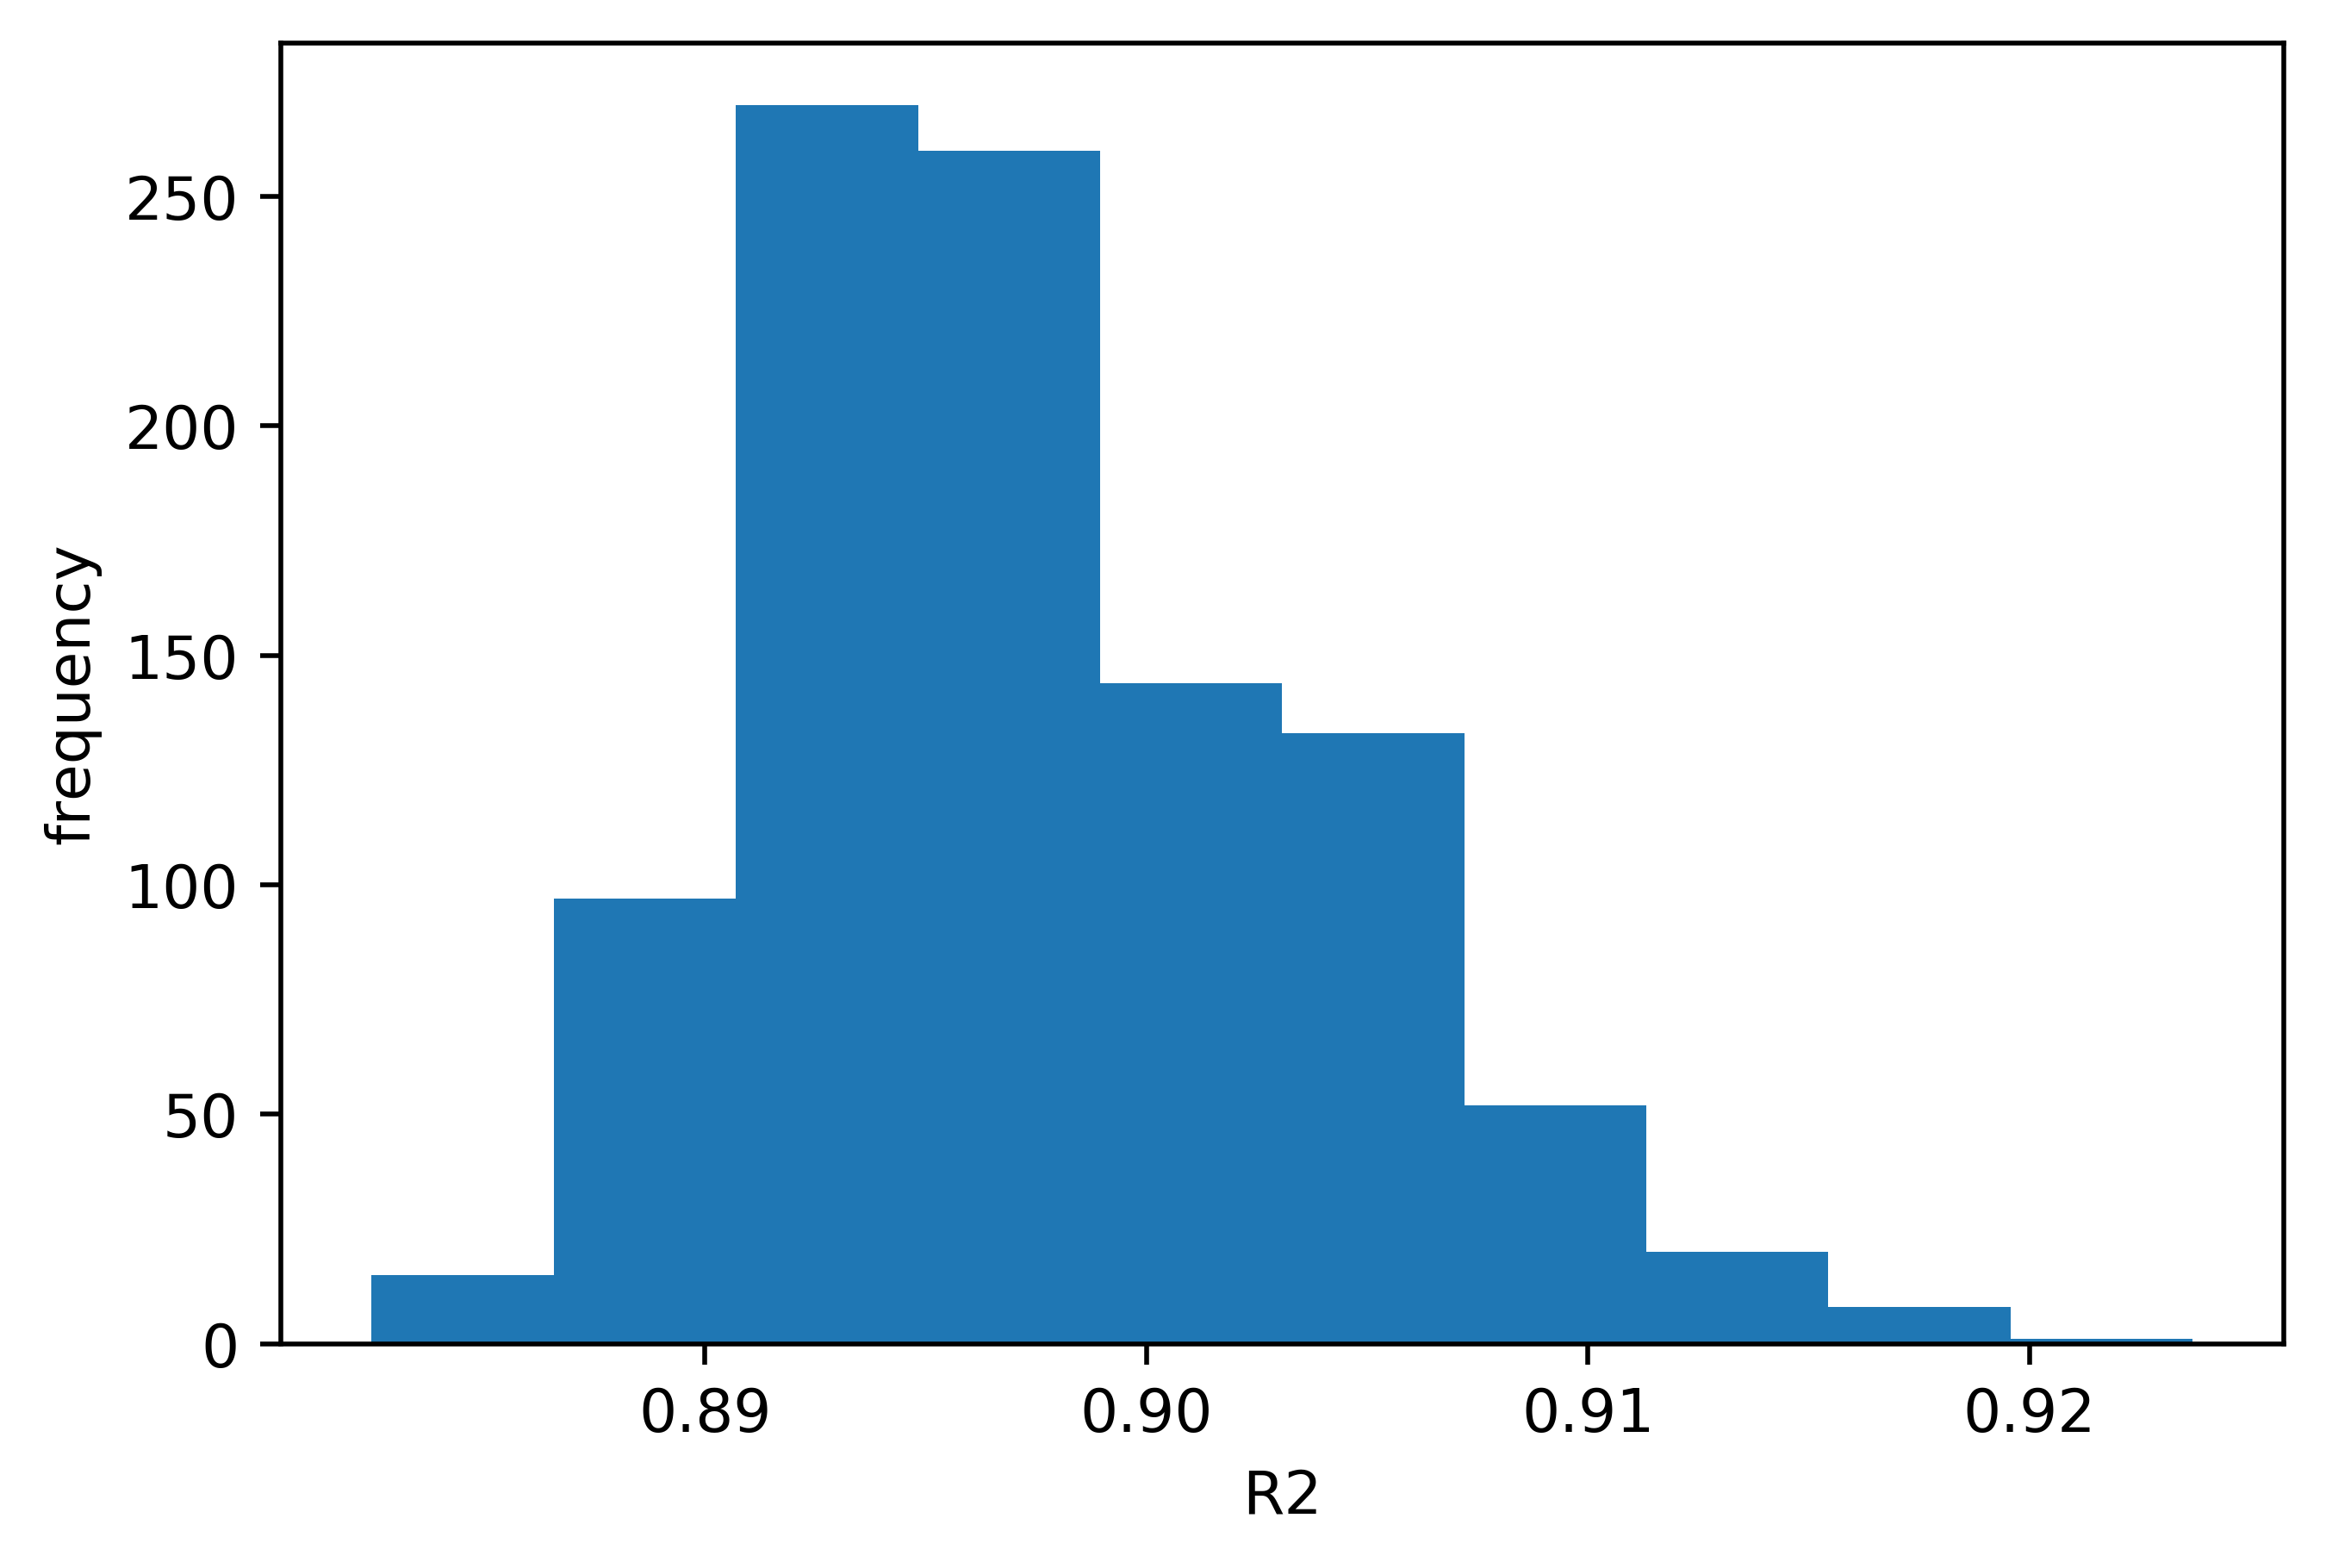

In [30]:
plt.hist(r2s[10])
plt.xlabel("R2")
plt.ylabel("frequency")
plt.savefig("r2_hist_at_10cpds.png")

In [31]:
print(r2s.keys())

dict_keys([3, 5, 10, 15, 20, 40, 60])


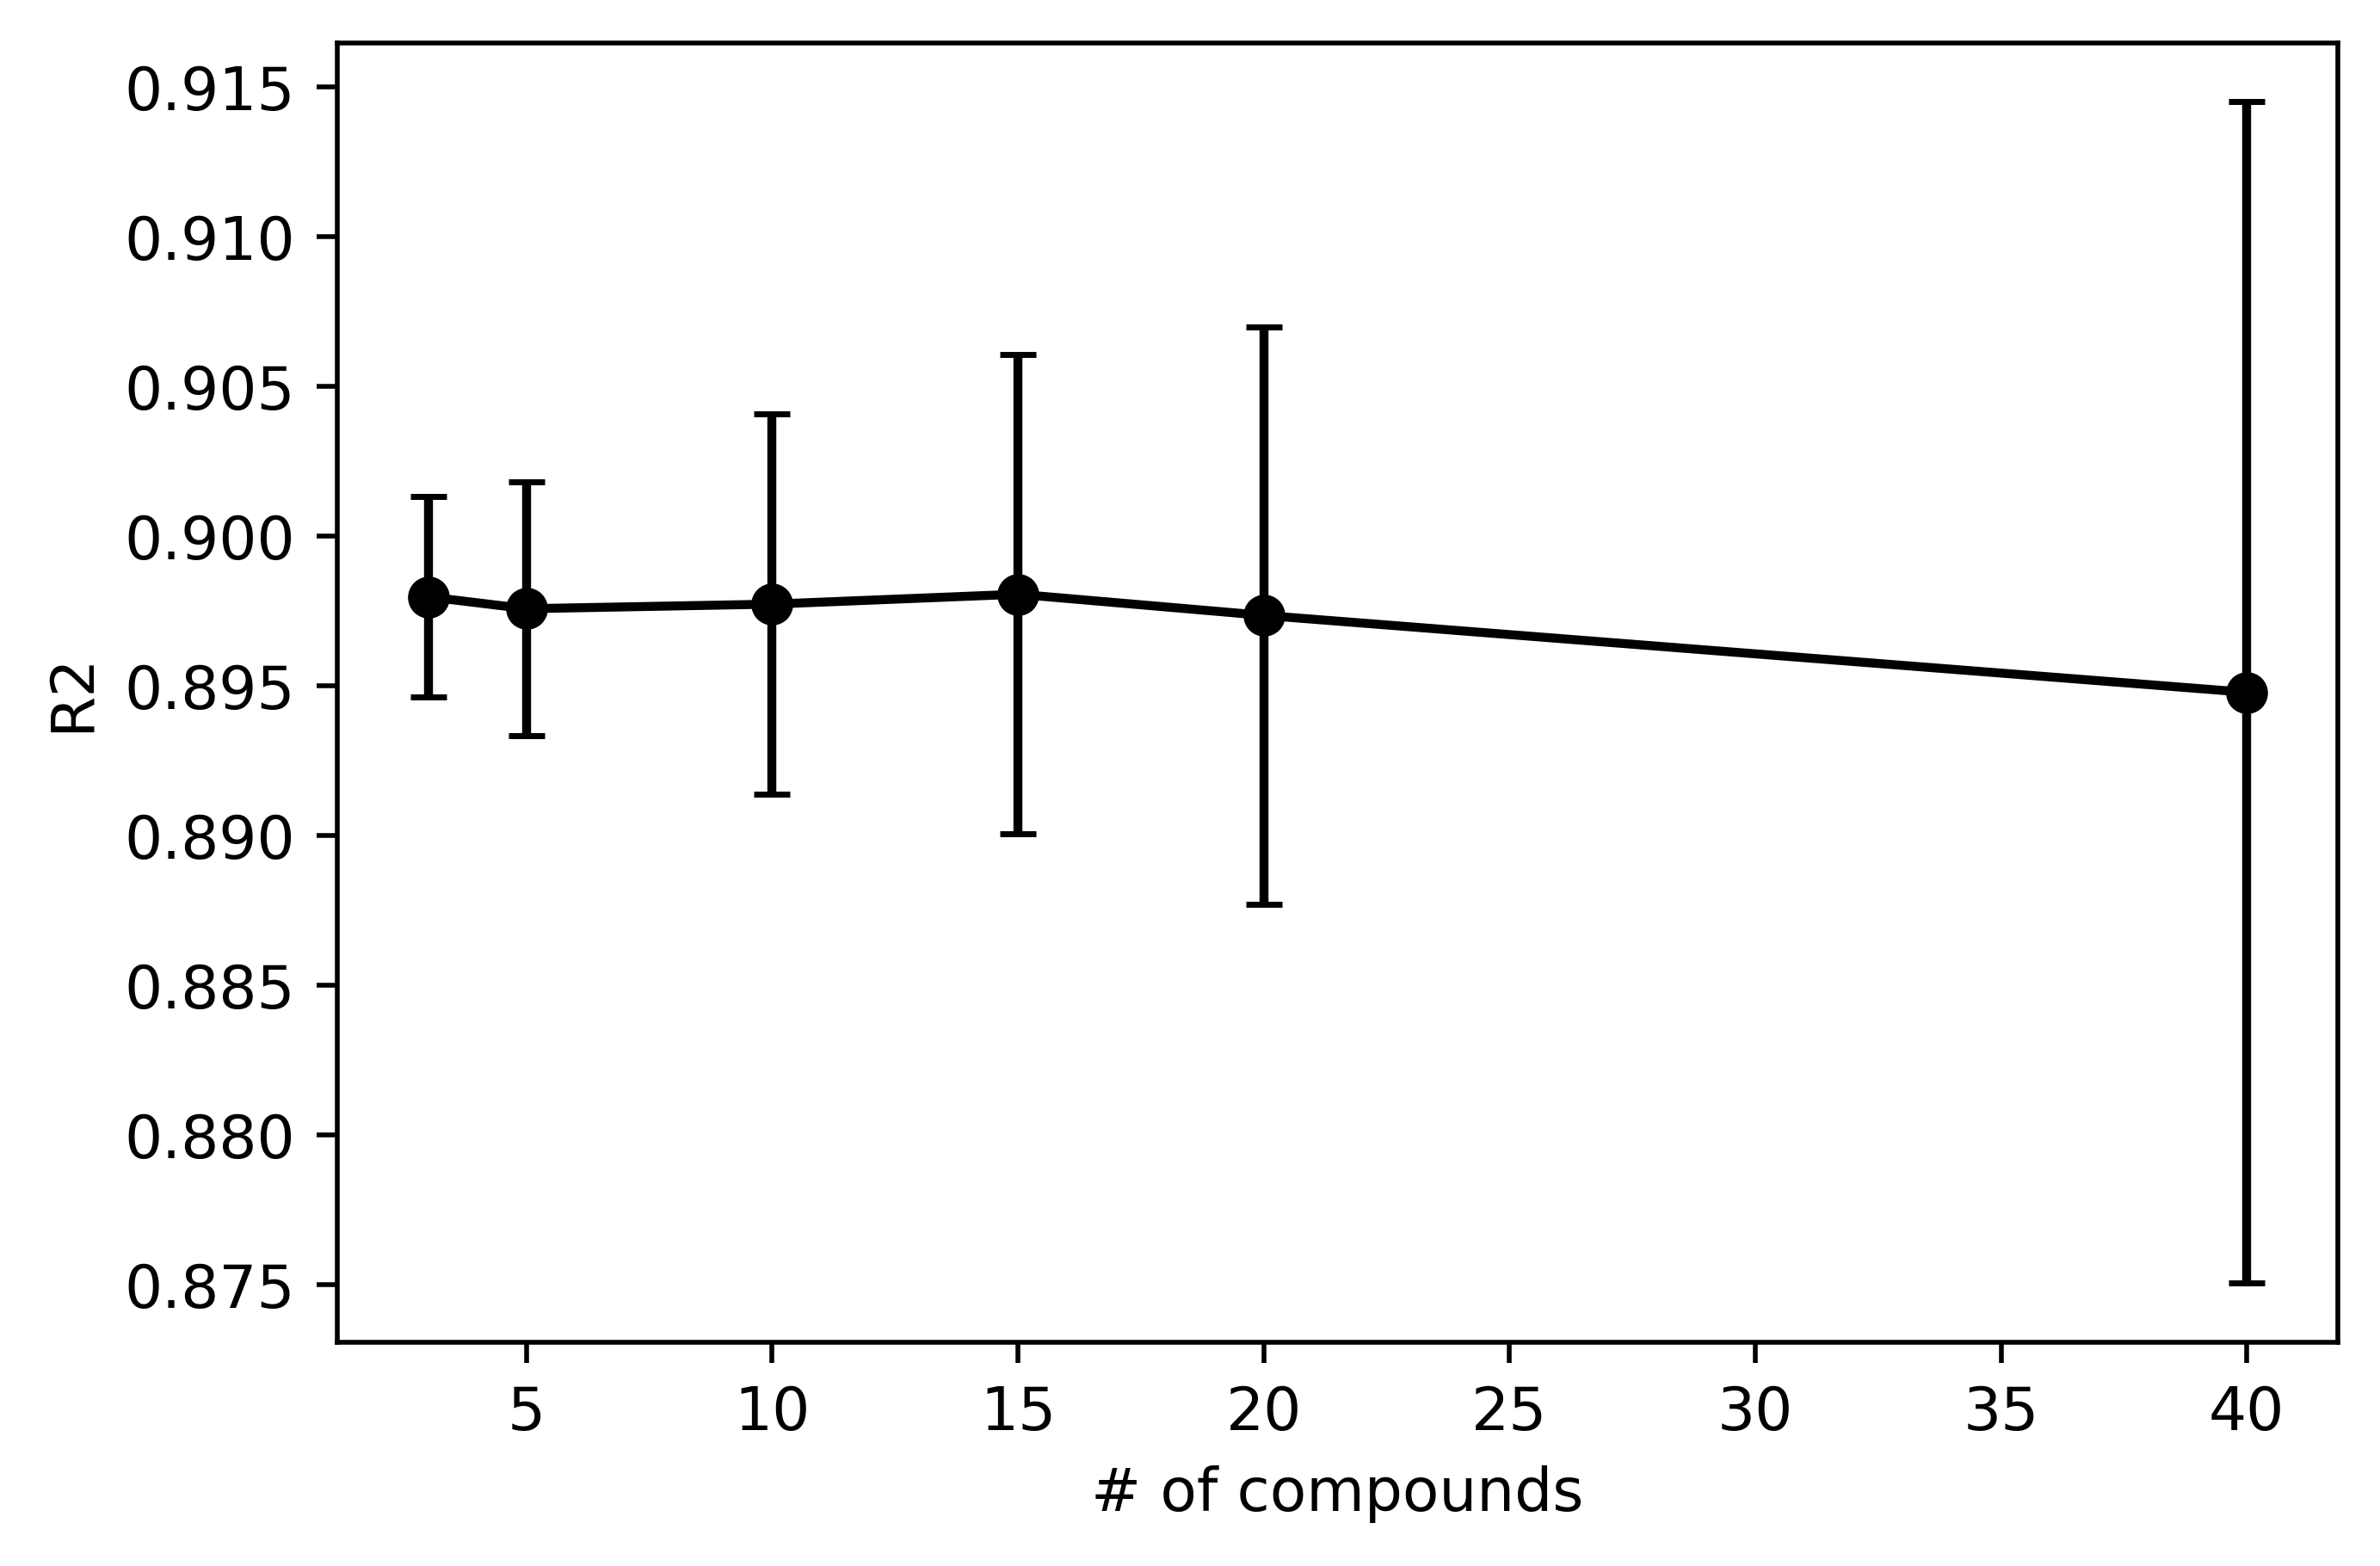

In [32]:
keys = list(r2s.keys())
keys.sort()
keys = keys[:-1]
vals = [np.mean(r2s[k]) for k in keys]
errs = [np.std(r2s[k]) for k in keys]
plt.scatter(keys,vals,color="black")
plt.errorbar(keys,vals,yerr=errs,color="black",capsize=3)
#plt.ylim((0,1.2))
plt.xlabel("# of compounds")
plt.ylabel("R2")
plt.savefig("num_cpds_plot.png")